# Modelo de Datos panel para proyecciones de Energía y Monto de Centrales Eléctricas

In [1]:
!pip install linearmodels pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 5.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from datetime import date

import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from linearmodels.panel import PanelOLS, PooledOLS

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler, LabelEncoder, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Obtención de Dataset

In [7]:
path = '/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/EnergiaMontos_CE_17-24.csv'
path_pred_input = '/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/Insumos_proyecciones/InsumosProyecciones_24-30.csv'

In [8]:
df = pd.read_csv(path)

df_input = pd.read_csv(path_pred_input)

print(df.info())
print(df.shape)

print('Dimension datos de entrada para proyecciones')
print(df_input.info())
print(df_input.shape)


df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18655 entries, 0 to 18654
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        18655 non-null  object 
 1   ANIO         18655 non-null  int64  
 2   MES          18655 non-null  int64  
 3   CLV_CENTRAL  18655 non-null  object 
 4   TIPO_TEC     18655 non-null  object 
 5   ENERGIA      18655 non-null  float64
 6   MONTO_NETO   18655 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1020.3+ KB
None
(18655, 7)
Dimension datos de entrada para proyecciones
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23149 entries, 0 to 23148
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FECHA         23149 non-null  object 
 1   FECHA_STRING  23149 non-null  object 
 2   ANIO          23149 non-null  int64  
 3   MES           23149 non-null  int64  
 4   CLV_CENTRAL   23

,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO
0,2017-01-01,2017,1,CCM,CC,214765.105247,1.467179e+08
1,2017-01-01,2017,1,PER,EO,2766.589000,1.672234e+06
2,2017-01-01,2017,1,PFC,FV,498.640000,2.953745e+05
3,2017-01-01,2017,1,PJZ,CC,282142.861000,1.945347e+08
4,2017-01-01,2017,1,01IUB,FV,84.390000,9.109799e+04


In [9]:
df_input.head()

,FECHA,FECHA_STRING,ANIO,MES,CLV_CENTRAL,TIPO_TEC,PML_MTR,ENERGIA,MONTO_NETO,E_FORECAST,ENERGIA_FC,MONTO_FC
0,01/01/24,2024-01-01,2024,1,CCM,CC,2342.34,197130.670100,6.592127e+08,0.021,201270.4142,6.730562e+08
1,01/02/24,2024-02-01,2024,2,CCM,CC,1042.57,128702.510953,1.643822e+08,0.021,131405.2637,1.678342e+08
2,01/03/24,2024-03-01,2024,3,CCM,CC,715.57,343642.705121,3.372991e+08,0.021,350859.2019,3.443824e+08
3,01/04/24,2024-04-01,2024,4,CCM,CC,550.73,314958.835802,2.649787e+08,0.021,321572.9714,2.705433e+08
4,01/05/24,2024-05-01,2024,5,CCM,CC,377.91,345980.568011,1.791230e+08,0.021,353246.1599,1.828846e+08


In [10]:
df['fecha'] = pd.to_datetime(df['FECHA'])
df_input['fecha_lp'] = pd.to_datetime(df_input['FECHA_STRING'])

df = df.loc[df['fecha'] <= '2023-12-01']
df_input = df_input.loc[df_input['fecha_lp'] <= '2030-12-01']

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18057 entries, 0 to 18056
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA        18057 non-null  object        
 1   ANIO         18057 non-null  int64         
 2   MES          18057 non-null  int64         
 3   CLV_CENTRAL  18057 non-null  object        
 4   TIPO_TEC     18057 non-null  object        
 5   ENERGIA      18057 non-null  float64       
 6   MONTO_NETO   18057 non-null  float64       
 7   fecha        18057 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 1.2+ MB
None


,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,fecha
0,2017-01-01,2017,1,CCM,CC,214765.105247,1.467179e+08,2017-01-01
1,2017-01-01,2017,1,PER,EO,2766.589000,1.672234e+06,2017-01-01
2,2017-01-01,2017,1,PFC,FV,498.640000,2.953745e+05,2017-01-01
3,2017-01-01,2017,1,PJZ,CC,282142.861000,1.945347e+08,2017-01-01
4,2017-01-01,2017,1,01IUB,FV,84.390000,9.109799e+04,2017-01-01


In [11]:
print(df_input.info())
df_input.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23149 entries, 0 to 23148
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FECHA         23149 non-null  object        
 1   FECHA_STRING  23149 non-null  object        
 2   ANIO          23149 non-null  int64         
 3   MES           23149 non-null  int64         
 4   CLV_CENTRAL   23149 non-null  object        
 5   TIPO_TEC      23149 non-null  object        
 6   PML_MTR       23149 non-null  float64       
 7   ENERGIA       23149 non-null  float64       
 8   MONTO_NETO    23149 non-null  float64       
 9   E_FORECAST    23149 non-null  float64       
 10  ENERGIA_FC    23149 non-null  float64       
 11  MONTO_FC      23149 non-null  float64       
 12  fecha_lp      23149 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 2.5+ MB
None


,FECHA,FECHA_STRING,ANIO,MES,CLV_CENTRAL,TIPO_TEC,PML_MTR,ENERGIA,MONTO_NETO,E_FORECAST,ENERGIA_FC,MONTO_FC,fecha_lp
0,01/01/24,2024-01-01,2024,1,CCM,CC,2342.34,197130.670100,6.592127e+08,0.021,201270.4142,6.730562e+08,2024-01-01
1,01/02/24,2024-02-01,2024,2,CCM,CC,1042.57,128702.510953,1.643822e+08,0.021,131405.2637,1.678342e+08,2024-02-01
2,01/03/24,2024-03-01,2024,3,CCM,CC,715.57,343642.705121,3.372991e+08,0.021,350859.2019,3.443824e+08,2024-03-01
3,01/04/24,2024-04-01,2024,4,CCM,CC,550.73,314958.835802,2.649787e+08,0.021,321572.9714,2.705433e+08,2024-04-01
4,01/05/24,2024-05-01,2024,5,CCM,CC,377.91,345980.568011,1.791230e+08,0.021,353246.1599,1.828846e+08,2024-05-01


## Obtención dataframe con componentes de Series de Tiempo para cada Central

## Función para obtención automática de componentes de series de tiempo (Matriz X)

In [14]:

def obtieneSerieDescompuesta(df_input, target_variable, centrales_lst, decompose_type):

  df_lst = []
  missing_centrales = []

  for central in centrales_lst:
    #print(i)

    try:

      df_central = df_input.loc[df_input['CLV_CENTRAL'] == central]

      decompose = seasonal_decompose(df_central[target_variable], model=decompose_type)
      dict_decompose = {'central': central, 'target_variable': target_variable,  'target': df_central[target_variable],  'seasonal': decompose.seasonal, 'trend': decompose.trend, 'resid': decompose.resid, 'observed': decompose.observed}
      df_decompose = pd.DataFrame(dict_decompose)


      # Llena valores nulos
      df_decompose['trend'].fillna(df_decompose['trend'].median(), inplace=True)
      df_decompose['resid'].fillna(df_decompose['resid'].median(), inplace=True)

      df_lst.append(df_decompose)

    except BaseException as error:
      print(error)
      print(f'Error ubicado en el dataset de: {central}')
      missing_centrales.append(central)



      #break

  df = pd.concat(df_lst)

  return df, missing_centrales


## Obtención de dataframe para entrenar el modelo

In [15]:
# Preparación de datos para estimación de modelo de datos panel
target = 'MONTO_NETO'
centrales_lst = df['CLV_CENTRAL'].unique().tolist()
decompose_type = 'additive'

print(type(centrales_lst))
print(centrales_lst)



df_de = df.set_index(df['fecha'])
print(df_de.info())

df_de.head()

<class 'list'>
['CCM', 'PER', 'PFC', 'PJZ', '01IUB', '01IUN', '01TCC', '01VAE', '02BII', '02BNS', '02BSD', '02BSU', '02CBE', '02CGC', '02DBC', '02DED', '02DEM', '02EAT', '02EDP', '02EDS', '02EIN', '02EOA', '02EOC', '02EOD', '02EOT', '02ERT', '02ESN', '02ETS', '02EUR', '02EVM', '02EZO', '02FEI', '02FET', '02GEI', '02IDB', '02IIE', '02LRP', '02LVD', '02LVN', '02OAU', '02PDQ', '02PMO', '02PQM', '02PRI', '02SUD', '03AAR', '03BAJ', '03DMN', '03EPT', '03EVI', '03MAM', '03SAU', '03SOA', '03VQE', '04AGD', '04EPU', '04FEH', '04FEN', '04HLI', '04LCG', '04NNG', '04PCU', '04YRM', '05ENO', '05FED', '05GPP', '05IEL', '05KST', '05PTC', '05SYD', '05TCA', '05TCU', '05TDO', '05TTR', '05TUA', '05TUB', '06ATC', '06ATV', '06CAH', '06CDU', '06CSO', '06DNO', '06EAA', '06ECH', '06ECV', '06EMS', '06EOS', '06EPR', '06GEH', '06HUI', '06HUO', '06ICR', '06PFT', '06PQR', '06RBC', '06RBT', '06RIB', '06TMH', '06VKD', '06VKU', '07ASU', '07BJT', '08CPC', '08MDP', '08VAD', '08VLT', '08YUU', '06TSS', '03ECP', '03SET', '0

,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,fecha
fecha,,,,,,,,
2017-01-01,2017-01-01,2017,1,CCM,CC,214765.105247,1.467179e+08,2017-01-01
2017-01-01,2017-01-01,2017,1,PER,EO,2766.589000,1.672234e+06,2017-01-01
2017-01-01,2017-01-01,2017,1,PFC,FV,498.640000,2.953745e+05,2017-01-01
2017-01-01,2017-01-01,2017,1,PJZ,CC,282142.861000,1.945347e+08,2017-01-01
2017-01-01,2017-01-01,2017,1,01IUB,FV,84.390000,9.109799e+04,2017-01-01


In [16]:
df_decompose, missing_centrales = obtieneSerieDescompuesta(df_de, target, centrales_lst, decompose_type)

print(missing_centrales)

df_decompose.head()

You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Error ubicado en el dataset de: 02PMO
x must have 2 complete cycles requires 24 observations. x only has 18 observation(s)
Error ubicado en el dataset de: 04NNG
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Error ubicado en el dataset de: 03ESG
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Error ubicado en el dataset de: 08XIX
x must have 2 complete cycles requires 24 observations. x only has 23 observation(s)
Error ubicado en el dataset de: 05XEO
x must have 2 complete cycles requires 24 observations. x only has 23 observation(s)
Error ubicado en el dataset de: 07SRE
x must have 2 complete cycles requires 24 observations. x only has 22 observation(s)
Error ubicado en el dataset de: 08PMN
x must have 2 complete cycles r

,central,target_variable,target,seasonal,trend,resid,observed
fecha,,,,,,,
2017-01-01,CCM,MONTO_NETO,1.467179e+08,-8.564074e+07,3.227828e+08,-2.818093e+07,1.467179e+08
2017-02-01,CCM,MONTO_NETO,8.356557e+07,-1.144985e+08,3.227828e+08,-2.818093e+07,8.356557e+07
2017-03-01,CCM,MONTO_NETO,1.070203e+08,-1.710003e+08,3.227828e+08,-2.818093e+07,1.070203e+08
2017-04-01,CCM,MONTO_NETO,1.043943e+08,-1.622603e+08,3.227828e+08,-2.818093e+07,1.043943e+08
2017-05-01,CCM,MONTO_NETO,1.397430e+08,-7.737221e+07,3.227828e+08,-2.818093e+07,1.397430e+08


## Obtención de dataframe de insumos para proyecciones de LP

In [20]:
# Preparación de datos de entrada para proyección para la función
target = 'MONTO_FC'
centrales_lst = df_input['CLV_CENTRAL'].unique().tolist()

print(type(centrales_lst))
print(centrales_lst)

df_input_de = df_input.set_index(df_input['fecha_lp'])




print(df_input_de.info())

df_input_de.head()


<class 'list'>
['CCM', 'PER', 'PFC', 'PJZ', '01FTD', '01GTT', '01IAO', '01IUB', '01IUN', '01PLA', '01QMS', '01RHI', '01SFA', '01TCC', '01VAE', '01VMD', '02BII', '02BNS', '02BSD', '02BSU', '02CBE', '02CGC', '02CUY', '02DBC', '02DED', '02DEM', '02EAT', '02EDP', '02EDS', '02EES', '02EIN', '02EOA', '02EOC', '02EOD', '02EOT', '02ERT', '02ESN', '02ETS', '02EUR', '02EVM', '02EZO', '02FEI', '02FET', '02GEI', '02GEM', '02IIE', '02LRP', '02LVD', '02LVN', '02MGD', '02NXL', '02OAU', '02PDQ', '02PIE', '02PIV', '02PQM', '02PRI', '02SDN', '02SUD', '02SXO', '02TYH', '03ADF', '03BAJ', '03BPS', '03CFO', '03CTI', '03CVS', '03DIG', '03DIJ', '03DMN', '03ECP', '03ELP', '03EPT', '03ESG', '03EVI', '03FAP', '03FOJ', '03GDA', '03GJR', '03HEI', '03HOU', '03IBB', '03JAC', '03LLI', '03LLJ', '03LLS', '03LPV', '03MAM', '03MXD', '03MXU', '03PEB', '03PFP', '03PHA', '03PTR', '03SAS', '03SAU', '03SDJ', '03SET', '03SGE', '03SGF', '03SOA', '03SOO', '03SOU', '03SQR', '03SSS', '03SUE', '03SUG', '03SUP', '03TRZ', '03TUE', '0

,FECHA,FECHA_STRING,ANIO,MES,CLV_CENTRAL,TIPO_TEC,PML_MTR,ENERGIA,MONTO_NETO,E_FORECAST,ENERGIA_FC,MONTO_FC,fecha_lp
fecha_lp,,,,,,,,,,,,,
2024-01-01,01/01/24,2024-01-01,2024,1,CCM,CC,2342.34,197130.670100,6.592127e+08,0.021,201270.4142,6.730562e+08,2024-01-01
2024-02-01,01/02/24,2024-02-01,2024,2,CCM,CC,1042.57,128702.510953,1.643822e+08,0.021,131405.2637,1.678342e+08,2024-02-01
2024-03-01,01/03/24,2024-03-01,2024,3,CCM,CC,715.57,343642.705121,3.372991e+08,0.021,350859.2019,3.443824e+08,2024-03-01
2024-04-01,01/04/24,2024-04-01,2024,4,CCM,CC,550.73,314958.835802,2.649787e+08,0.021,321572.9714,2.705433e+08,2024-04-01
2024-05-01,01/05/24,2024-05-01,2024,5,CCM,CC,377.91,345980.568011,1.791230e+08,0.021,353246.1599,1.828846e+08,2024-05-01


In [36]:
df_decompose_input, missing_centrales_pred = obtieneSerieDescompuesta(df_input_de, target, centrales_lst, decompose_type)

print(df_decompose_input.shape)
print(missing_centrales_pred)

df_decompose_input.head()

You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Error ubicado en el dataset de: 03ESG
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Error ubicado en el dataset de: 03SOA
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Error ubicado en el dataset de: 04EPD
(23023, 7)
['03ESG', '03SOA', '04EPD']


,central,target_variable,target,seasonal,trend,resid,observed
fecha_lp,,,,,,,
2024-01-01,CCM,MONTO_FC,6.730562e+08,4.176356e+08,3.066711e+08,-309256.529344,6.730562e+08
2024-02-01,CCM,MONTO_FC,1.678342e+08,-1.267235e+08,3.066711e+08,-309256.529344,1.678342e+08
2024-03-01,CCM,MONTO_FC,3.443824e+08,6.278019e+07,3.066711e+08,-309256.529344,3.443824e+08
2024-04-01,CCM,MONTO_FC,2.705433e+08,-1.720341e+07,3.066711e+08,-309256.529344,2.705433e+08
2024-05-01,CCM,MONTO_FC,1.828846e+08,-1.121474e+08,3.066711e+08,-309256.529344,1.828846e+08


In [24]:
df_decompose.reset_index(inplace=True)
df_decompose

,fecha,central,target_variable,target,seasonal,trend,resid,observed
0,2017-01-01,CCM,MONTO_NETO,1.467179e+08,-8.564074e+07,3.227828e+08,-2.818093e+07,1.467179e+08
1,2017-02-01,CCM,MONTO_NETO,8.356557e+07,-1.144985e+08,3.227828e+08,-2.818093e+07,8.356557e+07
2,2017-03-01,CCM,MONTO_NETO,1.070203e+08,-1.710003e+08,3.227828e+08,-2.818093e+07,1.070203e+08
3,2017-04-01,CCM,MONTO_NETO,1.043943e+08,-1.622603e+08,3.227828e+08,-2.818093e+07,1.043943e+08
4,2017-05-01,CCM,MONTO_NETO,1.397430e+08,-7.737221e+07,3.227828e+08,-2.818093e+07,1.397430e+08
...,...,...,...,...,...,...,...,...
17655,2023-08-01,07EOL,MONTO_NETO,4.771169e+07,2.160928e+07,4.294126e+07,1.164253e+06,4.771169e+07
17656,2023-09-01,07EOL,MONTO_NETO,3.558623e+07,-3.087236e+06,4.294126e+07,1.164253e+06,3.558623e+07
17657,2023-10-01,07EOL,MONTO_NETO,3.221181e+07,-4.658198e+06,4.294126e+07,1.164253e+06,3.221181e+07
17658,2023-11-01,07EOL,MONTO_NETO,3.661294e+07,6.840880e+06,4.294126e+07,1.164253e+06,3.661294e+07


# Analisis Exploratorio de Datos

In [25]:
# plt.plot(x1, y1)
px.line(df_decompose, 'fecha', 'target', color = 'central')




## Transformar dataframe a datos panel estableciendo multi-indice

In [26]:
df_decompose.set_index(['central','fecha'], inplace = True)
df_decompose.head()

target_variable        target      seasonal         trend  \
central fecha                                                                  
CCM     2017-01-01      MONTO_NETO  1.467179e+08 -8.564074e+07  3.227828e+08   
        2017-02-01      MONTO_NETO  8.356557e+07 -1.144985e+08  3.227828e+08   
        2017-03-01      MONTO_NETO  1.070203e+08 -1.710003e+08  3.227828e+08   
        2017-04-01      MONTO_NETO  1.043943e+08 -1.622603e+08  3.227828e+08   
        2017-05-01      MONTO_NETO  1.397430e+08 -7.737221e+07  3.227828e+08   

                           resid      observed  
central fecha                                   
CCM     2017-01-01 -2.818093e+07  1.467179e+08  
        2017-02-01 -2.818093e+07  8.356557e+07  
        2017-03-01 -2.818093e+07  1.070203e+08  
        2017-04-01 -2.818093e+07  1.043943e+08  
        2017-05-01 -2.818093e+07  1.397430e+08

# Estimación de modelo pool

In [27]:
variables_independientes = ['seasonal', 'trend', 'resid']

X = df_decompose[variables_independientes]
X = sm.add_constant(X)


y = df_decompose['target']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [29]:
mod = PooledOLS(y, X)
results = mod.fit()

print(results)

                          PooledOLS Estimation Summary                          
Dep. Variable:                 target   R-squared:                        0.9586
Estimator:                  PooledOLS   R-squared (Between):              0.9952
No. Observations:               17660   R-squared (Within):               0.8902
Date:                Sat, Mar 09 2024   R-squared (Overall):              0.9586
Time:                        20:31:54   Log-likelihood                -3.316e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.364e+05
Entities:                         276   P-value                           0.0000
Avg Obs:                       63.986   Distribution:                 F(3,17656)
Min Obs:                       24.000                                           
Max Obs:                       84.000   F-statistic (robust):          1.364e+05
                            

# Proyecciones de largo plazo

In [30]:
df_decompose_input.head()

,central,target_variable,target,seasonal,trend,resid,observed
fecha_lp,,,,,,,
2024-01-01,CCM,MONTO_FC,6.730562e+08,4.176356e+08,3.066711e+08,-309256.529344,6.730562e+08
2024-02-01,CCM,MONTO_FC,1.678342e+08,-1.267235e+08,3.066711e+08,-309256.529344,1.678342e+08
2024-03-01,CCM,MONTO_FC,3.443824e+08,6.278019e+07,3.066711e+08,-309256.529344,3.443824e+08
2024-04-01,CCM,MONTO_FC,2.705433e+08,-1.720341e+07,3.066711e+08,-309256.529344,2.705433e+08
2024-05-01,CCM,MONTO_FC,1.828846e+08,-1.121474e+08,3.066711e+08,-309256.529344,1.828846e+08


In [31]:
df_decompose_input.reset_index(inplace = True)
df_decompose_input.set_index(['central', 'fecha_lp'], inplace=True)


X_lp = df_decompose_input[variables_independientes]
X_lp = sm.add_constant(X_lp)

X_lp.head()

const      seasonal         trend          resid
central fecha_lp                                                    
CCM     2024-01-01    1.0  4.176356e+08  3.066711e+08 -309256.529344
        2024-02-01    1.0 -1.267235e+08  3.066711e+08 -309256.529344
        2024-03-01    1.0  6.278019e+07  3.066711e+08 -309256.529344
        2024-04-01    1.0 -1.720341e+07  3.066711e+08 -309256.529344
        2024-05-01    1.0 -1.121474e+08  3.066711e+08 -309256.529344

In [32]:
X_lp.tail()

const      seasonal         trend      resid
central fecha_lp                                                
08YUU   2030-08-01    1.0 -33953.354484  82061.683279  122.11984
        2030-09-01    1.0 -51315.527429  82061.683279  122.11984
        2030-10-01    1.0 -64622.520383  82061.683279  122.11984
        2030-11-01    1.0 -29218.487298  82061.683279  122.11984
        2030-12-01    1.0 -30974.644299  82061.683279  122.11984

In [35]:
y_pred_lp = results.predict(X_lp).sort_index(ascending=True)

print(type(y_pred_lp))
print(y_pred_lp)
print(y_pred_lp.shape)
y_pred_lp.head()

<class 'pandas.core.frame.DataFrame'>
                     predictions
central fecha_lp                
01FTD   2024-01-01  1.279020e+05
        2024-02-01  1.252945e+05
        2024-03-01  1.294057e+05
        2024-04-01  1.324069e+05
        2024-05-01  1.308106e+05
...                          ...
PJZ     2030-08-01  6.374149e+08
        2030-09-01  1.518516e+08
        2030-10-01  3.230072e+08
        2030-11-01  1.565483e+08
        2030-12-01  1.600792e+08

[23023 rows x 1 columns]
(23023, 1)


predictions
central fecha_lp                 
01FTD   2024-01-01  127902.001920
        2024-02-01  125294.476456
        2024-03-01  129405.659864
        2024-04-01  132406.858705
        2024-05-01  130810.645506

In [ ]:
print(type(df_decompose))
df_decompose.head()

y_df = df_decompose[['target']]

y_df.head()

<class 'pandas.core.frame.DataFrame'>


target
central fecha                   
CCM     2017-01-01  1.467179e+08
        2017-02-01  8.356557e+07
        2017-03-01  1.070203e+08
        2017-04-01  1.043943e+08
        2017-05-01  1.397430e+08

In [ ]:
y_pred_lp.reset_index(inplace=True)
y_df.reset_index(inplace=True)


name_dict = {'fecha_lp': 'fecha' ,'predictions': 'target'}
y_pred_lp.rename(columns= name_dict, inplace=True)

print(y_pred_lp)
print(y_df)

df_array = [y_df, y_pred_lp]

df_all = pd.concat(df_array)

      central      fecha        target
0       01FTD 2028-05-01  1.567081e+05
1       01FTD 2028-06-01  1.487044e+05
2       01FTD 2028-07-01  1.421600e+05
3       01FTD 2028-08-01  1.623885e+05
4       01FTD 2028-09-01  1.550182e+05
...       ...        ...           ...
17655     PJZ 2030-08-01  2.010459e+08
17656     PJZ 2030-09-01  1.873928e+08
17657     PJZ 2030-10-01  1.813060e+08
17658     PJZ 2030-11-01  1.463381e+08
17659     PJZ 2030-12-01  1.167898e+08

[17660 rows x 3 columns]
      central      fecha        target
0         CCM 2017-01-01  1.467179e+08
1         CCM 2017-02-01  8.356557e+07
2         CCM 2017-03-01  1.070203e+08
3         CCM 2017-04-01  1.043943e+08
4         CCM 2017-05-01  1.397430e+08
...       ...        ...           ...
17655   07EOL 2023-08-01  4.771169e+07
17656   07EOL 2023-09-01  3.558623e+07
17657   07EOL 2023-10-01  3.221181e+07
17658   07EOL 2023-11-01  3.661294e+07
17659   07EOL 2023-12-01  4.066979e+07

[17660 rows x 3 columns]


## Gráfica proyecciones de largo plazo

<Axes: xlabel='fecha', ylabel='target'>

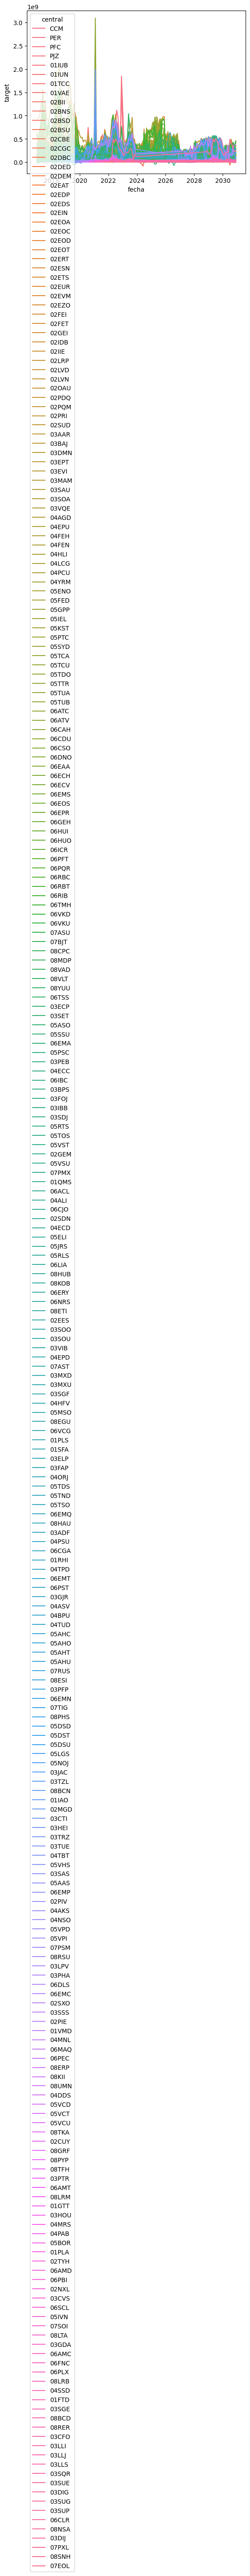

In [ ]:
# #plt.plot(y, label='monto', color='green')
# plt.plot(y, label='monto', color='blue')
# plt.plot(y_pred, label= 'monto estimado LP', color='red')
# #plt.plot(y_pred_lp, label= 'monto estimado LP', color='yellow')

# #add legend
# plt.legend(title='Serie')
# plt.title(f'Estimación de montos netos')
# plt.xlabel(f'Periodo')
# plt.ylabel(f'$')


#df_all = df_all.sort_values(by=[['central', 'fecha']], ascending=True)
sns.lineplot(data=df_all, x="fecha", y="target", hue="central")


In [ ]:
df_all.to_excel(f'/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/Estimaciones_LP/estimaciones_LP_{target}.xlsx')